In [ ]:
!pip install control

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 29.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 20
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, -self.max_input, self.max_input)[0]
            
            P = 29.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 1-y[-1]
            self.j+=1
            P1 = 29.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -(self.e2)**2

            if self.j >= 700:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 20
lower_bound = -20

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 160
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(100000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -38.296621345032186
Episode * 1 * Episodic Reward is ==> -39.01985328154795
Episode * 2 * Episodic Reward is ==> -38.94561085363883
Episode * 3 * Episodic Reward is ==> -37.83955100210235
Episode * 4 * Episodic Reward is ==> -38.344786564175934
Episode * 5 * Episodic Reward is ==> -39.23128614514485
Episode * 6 * Episodic Reward is ==> -38.15117863882433
Episode * 7 * Episodic Reward is ==> -38.531619957258734
Episode * 8 * Episodic Reward is ==> -37.8668411805887
Episode * 9 * Episodic Reward is ==> -38.17023205763936
Episode * 10 * Episodic Reward is ==> -37.5289505464712
Episode * 11 * Episodic Reward is ==> -37.62220330290647
Episode * 12 * Episodic Reward is ==> -28.66274711997239
Episode * 13 * Episodic Reward is ==> -31.64548464870326
Episode * 14 * Episodic Reward is ==> -31.864048951408797
Episode * 15 * Episodic Reward is ==> -31.638110830766713
Episode * 16 * Episodic Reward is ==> -33.34595599641323
Episode * 17 * Episodic Reward is ==> 

KeyboardInterrupt: ignored

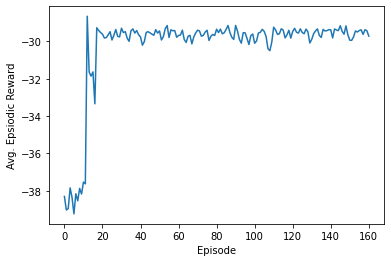

In [ ]:
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
actor_model.save_weights("actor.h5")
critic_model.save_weights("critic.h5")

target_actor.save_weights("target_actor.h5")
target_critic.save_weights("target_critic.h5")

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -31317.92979701686
Episode * 1 * Episodic Reward is ==> -20403.090725787137
Episode * 2 * Episodic Reward is ==> -31189.40630671965
Episode * 3 * Episodic Reward is ==> -31295.60767318684
Episode * 4 * Episodic Reward is ==> -30911.135367942075
Episode * 5 * Episodic Reward is ==> -30926.201452947516
Episode * 6 * Episodic Reward is ==> -30907.22946629247
Episode * 7 * Episodic Reward is ==> -30906.466460681102
Episode * 8 * Episodic Reward is ==> -30946.965018951214
Episode * 9 * Episodic Reward is ==> -30949.36195179762


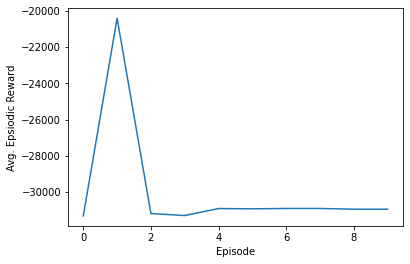

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 34.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 500
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, -self.max_input, self.max_input)[0]
            
            P = 34.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 34.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -(self.e2)**2

            if self.j >= 700:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 500
lower_bound = -500

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(100000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
actor_model.save_weights("10actor.h5")
critic_model.save_weights("10critic.h5")

target_actor.save_weights("10target_actor.h5")
target_critic.save_weights("10target_critic.h5")

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -30588.19241705189
Episode * 1 * Episodic Reward is ==> -31344.196881767024
Episode * 2 * Episodic Reward is ==> -31348.195705950155
Episode * 3 * Episodic Reward is ==> -31236.226880870403
Episode * 4 * Episodic Reward is ==> -31273.607275714534
Episode * 5 * Episodic Reward is ==> -31296.7670064625
Episode * 6 * Episodic Reward is ==> -31286.479980018496
Episode * 7 * Episodic Reward is ==> -31285.117639957545
Episode * 8 * Episodic Reward is ==> -31310.33023292563
Episode * 9 * Episodic Reward is ==> -31313.03050196858
Episode * 10 * Episodic Reward is ==> -31317.55776639879
Episode * 11 * Episodic Reward is ==> -31313.263601332263
Episode * 12 * Episodic Reward is ==> -31261.658522321126
Episode * 13 * Episodic Reward is ==> -31252.529093542056
Episode * 14 * Episodic Reward is ==> -31274.52634832171
Episode * 15 * Episodic Reward is ==> -31253.705964393008
Episode * 16 * Episodic Reward is ==> -31269.431496604084
Episode * 17 * Episodic Reward 

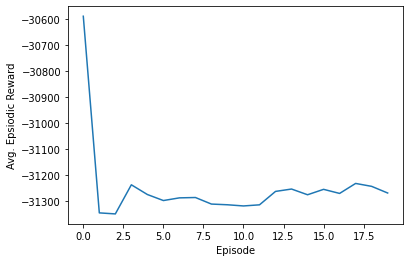

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 34.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 500
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, -self.max_input, self.max_input)[0]
            
            P = 34.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 34.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -(self.e2)**2

            if self.j >= 700:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 500
lower_bound = -500

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 20
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(100000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
actor_model.save_weights("20actor.h5")
critic_model.save_weights("20critic.h5")

target_actor.save_weights("20target_actor.h5")
target_critic.save_weights("20target_critic.h5")

In [ ]:
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -669.2923905143066
Episode * 0 * Avg Action is ==> 48.787734449332255
Episode * 1 * Episodic Reward is ==> -667.9182130652644
Episode * 1 * Avg Action is ==> 48.584209807373675
Episode * 2 * Episodic Reward is ==> -671.4704379797429
Episode * 2 * Avg Action is ==> 49.0260615659248
Episode * 3 * Episodic Reward is ==> -669.3265345455233
Episode * 3 * Avg Action is ==> 48.46167705966349
Episode * 4 * Episodic Reward is ==> -678.1097630920178
Episode * 4 * Avg Action is ==> 50.510698470367394
Episode * 5 * Episodic Reward is ==> -683.0643979272736
Episode * 5 * Avg Action is ==> 50.76714741038688
Episode * 6 * Episodic Reward is ==> -679.7579422340341
Episode * 6 * Avg Action is ==> 51.72708223519089
Episode * 7 * Episodic Reward is ==> -678.3922237969341
Episode * 7 * Avg Action is ==> 50.51604347587667
Episode * 8 * Episodic Reward is ==> -691.0552196767107
Episode * 8 * Avg Action is ==> 52.198891133304144
Episode * 9 * Episodic Reward is ==> -680.8

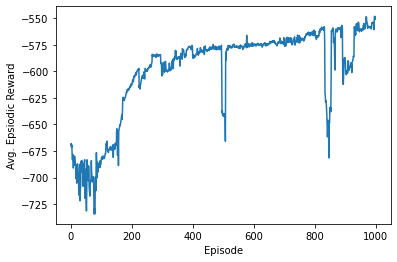

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 34.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 100
            #self.e0 = 0
            self.e1 = 30
            self.e2 = 30
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 30
            self.e2 = 30
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, -self.max_input, self.max_input)[0]
            
            P = 34.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            uu = self.u + self.rl 
 
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 34.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            #reward = -(self.e2)**2
            reward = -np.absolute(self.e2)

            if self.j >= 500:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 100
lower_bound = -100

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.001
actor_lr = 0.0001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.0005

buffer = Buffer(100000, 128)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0
    episodic_action = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        episodic_action += action[0]

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    print("Episode * {} * Avg Action is ==> {}".format(ep, episodic_action/500))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
pisode * 445 * Avg Action is ==> 23.622088526907206
Episode * 446 * Episodic Reward is ==> -554.8173259769125
Episode * 446 * Avg Action is ==> 22.107861473494474
Episode * 447 * Episodic Reward is ==> -562.1585233577445
Episode * 447 * Avg Action is ==> 22.35101448271628
Episode * 448 * Episodic Reward is ==> -555.1460709389372
Episode * 448 * Avg Action is ==> 20.41383171602479
Episode * 449 * Episodic Reward is ==> -552.7534893044752
Episode * 449 * Avg Action is ==> 21.621465369075917

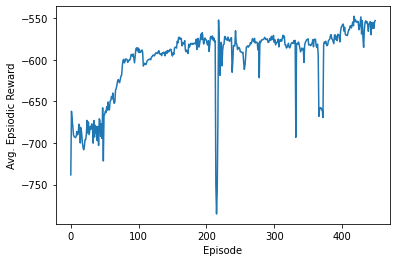

In [ ]:
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
actor_model.save_weights("y5actor.h5")
critic_model.save_weights("y5critic.h5")

target_actor.save_weights("y5target_actor.h5")
target_critic.save_weights("y5target_critic.h5")

In [ ]:
import pandas as pd
df = pd.DataFrame(ep_reward_list)
df.to_csv (r'training4.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.linspace(0,4,50)
y = func(x, 2.5, 1.3, 0.5)
yn = y + 0.2*np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, yn)
popt

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 29.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 100
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, -self.max_input, self.max_input)[0]
            
            P = 29.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 29.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -(self.e2)**2

            if self.j >= 500:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 100
lower_bound = -100

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.1
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 200
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(10000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -15583.692371196457
Episode * 1 * Episodic Reward is ==> -15721.728900749196


KeyboardInterrupt: ignored

In [ ]:
actor_model.save_weights("80actor.h5")
critic_model.save_weights("80critic.h5")

target_actor.save_weights("80target_actor.h5")
target_critic.save_weights("80target_critic.h5")

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -30608.676069160778
Episode * 1 * Episodic Reward is ==> -31339.239198267594
Episode * 2 * Episodic Reward is ==> -31345.55314530479
Episode * 3 * Episodic Reward is ==> -31348.563042187907
Episode * 4 * Episodic Reward is ==> -31349.40910323367
Episode * 5 * Episodic Reward is ==> -31370.69205430628
Episode * 6 * Episodic Reward is ==> -31332.349013007704
Episode * 7 * Episodic Reward is ==> -31347.255992162263
Episode * 8 * Episodic Reward is ==> -31354.986335336696
Episode * 9 * Episodic Reward is ==> -31305.191184348918
Episode * 10 * Episodic Reward is ==> -31360.218749776133
Episode * 11 * Episodic Reward is ==> -31355.35929953813
Episode * 12 * Episodic Reward is ==> -31356.767766769062
Episode * 13 * Episodic Reward is ==> -31375.052263182326
Episode * 14 * Episodic Reward is ==> -31339.187450550646
Episode * 15 * Episodic Reward is ==> -31365.653575262426
Episode * 16 * Episodic Reward is ==> -31352.86148198814
Episode * 17 * Episodic Rewar

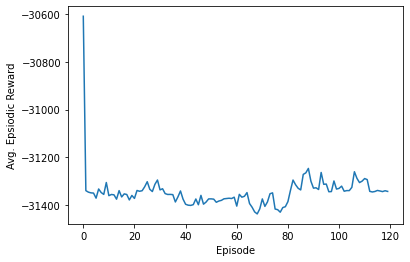

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 34.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 500
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, -self.max_input, self.max_input)[0]
            
            P = 34.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 34.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -(self.e2)**2

            if self.j >= 700:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 500
lower_bound = -500

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 120
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(100000, 256)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
actor_model.save_weights("120actor.h5")
critic_model.save_weights("120critic.h5")

target_actor.save_weights("120target_actor.h5")
target_critic.save_weights("120target_critic.h5")

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 34.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 100
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, 0, self.max_input)[0]
            
            P = 34.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 34.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -(self.e2)**2

            if self.j >= 500:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 100
lower_bound = 0

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(100000, 32)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -12430.936063193967
Episode * 1 * Episodic Reward is ==> -12430.936063193967
Episode * 2 * Episodic Reward is ==> -12430.936063193967
Episode * 3 * Episodic Reward is ==> -12430.936063193967
Episode * 4 * Episodic Reward is ==> -12430.936063193967


KeyboardInterrupt: ignored

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 29.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 100
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, -self.max_input, self.max_input)[0]
            
            P = 29.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 29.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -(self.e2)**2

            if self.j >= 500:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 100
lower_bound = -100

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 10
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 500
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(100000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -13215.179822516115
Episode * 1 * Episodic Reward is ==> -13139.222396237554
Episode * 2 * Episodic Reward is ==> -13231.645290591117
Episode * 3 * Episodic Reward is ==> -13256.376155605321
Episode * 4 * Episodic Reward is ==> -13177.149286341775
Episode * 5 * Episodic Reward is ==> -13234.172935284188
Episode * 6 * Episodic Reward is ==> -13288.203399847178
Episode * 7 * Episodic Reward is ==> -13171.402752629561
Episode * 8 * Episodic Reward is ==> -13372.60192617124
Episode * 9 * Episodic Reward is ==> -13224.772791379062
Episode * 10 * Episodic Reward is ==> -13379.601169985455
Episode * 11 * Episodic Reward is ==> -13245.847742838952
Episode * 12 * Episodic Reward is ==> -13200.963014646666
Episode * 13 * Episodic Reward is ==> -13449.212366439557
Episode * 14 * Episodic Reward is ==> -13217.66010954223
Episode * 15 * Episodic Reward is ==> -13202.915642503176
Episode * 16 * Episodic Reward is ==> -13207.347387097343
Episode * 17 * Episodic Re

KeyboardInterrupt: ignored